In [2]:
from scipy.stats import expon
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
import dill
from astropy import visualization as vis
from gammapy.data import DataStore, Observation
import scanner_interpretation as scani
from corner import corner

# with open("pkl_jugs/reduced_with_significance.pkl","rb") as f:
#     reduced = dill.load(f)

print("Getting Reduced")
reduced = scani.Reduced("pkl_jugs/reduced_correctedP_020923.pkl")
# print("Loading metadata (~40sec)")
# reduced.loadMetadata("pkl_jugs/navigationtable.pkl")
# reduced.loadNavtable("pkl_jugs/navigationtable.pkl")
# reduced.loadObservations()


Getting Reduced


In [30]:

pval_0_mask = reduced.reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.
bernP_nan_mask = np.isnan(reduced.reduced["BERNOULLI_P"])
expP_nan_mask = np.isnan(reduced.reduced["EXP_CORRECTED_P"])
bernP_finite_mask = np.isfinite(reduced.reduced["BERNOULLI_P"])
expP_finite_mask = np.isfinite(reduced.reduced["EXP_CORRECTED_P"])
bernP_0_mask = reduced.reduced["BERNOULLI_P"] == 0
expP_0_mask = reduced.reduced["EXP_CORRECTED_P"] == 0

sanebern = ~bernP_nan_mask * bernP_finite_mask * ~bernP_0_mask
saneexp = ~expP_nan_mask * expP_finite_mask * ~expP_0_mask

leftover = sanebern * saneexp

In [36]:
from scipy.special import erfinv 

def n_sigmas(p):
    return (2**0.5)*erfinv(1.-p)
reduced.reduced["SIGMA"] = n_sigmas(reduced.reduced["BERNOULLI_P"])


Nmax,OBS_ID,ID,RA,DEC,TIME,ENERGY,dt,da,MEDIAN_RA,MEDIAN_DEC,SkyCoord,MEDIAN_GLAT,MEDIAN_GLON,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG,DS_INDEX,ANGULAR_MEASURE_DEG,BKG_DT_LAMBDA,BKG_PHOTONS,MPLET_DT_LAMBDA,LAMBDA_RATIO_SIGNIFICANCE,PNT_DISTANCE,ALT_PNT,BELL_FRACTION,EXP_CORRECTED_P,BERNOULLI_P,LOG_BERN_P,LOG_EXP_CORR_P,SIGMA
,,,,,,,,,,,"deg,deg",deg,deg,,,,,,,,,,,,,,,,,
int64,uint32,object,object,object,object,object,float64,float64,float64,float64,SkyCoord,float64,float64,str21,str22,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4,35007,[12300786336303 12300786336309 12300786336358 12305081303052],[0.58403856 0.526088 0.45749614 0.4166997 ],[-31.82828 -31.751549 -31.768085 -31.768494],['2006-09-24T22:28:53.679578835' '2006-09-24T22:28:53.709489638'\n '2006-09-24T22:28:53.971949393' '2006-09-24T22:28:54.285595948'],[0.40224195 0.19593626 0.30666494 0.5964279 ],606017024.0,0.177698162902297,0.49179208278656006,-31.76828956604004,"0.49179208278656006,-31.76828956604004",-78.28313920052501,6.65861855121281,NGC 253,Starburst,13.000918161333757,0,0.056336131063859166,0.002343300317735979,4,4.950355255066865e-09,5.345723863570129e-13,1.1460470590280671,81.2128422884387,0.0008089494076557457,1.582010297340254e-05,1.5819978994802142e-05,-4.8007940974785175,-4.800790693996689,4.316950259487835
4,37615,[562640716443 566935683087 566935683133 566935683231],[140.07527 139.87529 140.04926 139.97379],[-12.65749 -12.658391 -12.629856 -12.703779],['2007-03-16T21:49:46.793585593' '2007-03-16T21:49:47.207861478'\n '2007-03-16T21:49:47.454605633' '2007-03-16T21:49:48.005210692'],[0.37894204 0.18589914 0.3592743 0.45619166],1211624960.0,0.1999837201324952,140.0115203857422,-12.657939910888672,"140.0115203857422,-12.657939910888672",25.119606431918168,243.739115224072,MRC 0910-208,HBL,8.58048984270526,0,0.07505480720964741,0.0007094210947816386,2,2.4760134157636825e-09,7.172040739078511e-14,0.4952118461564096,67.18204221907,0.0018678108463063836,9.192507669236182e-07,9.19249193986893e-07,-6.036566742255617,-6.03656599913051,4.908181169238832
3,45439,[3036541878333 3036541878334 3036541878336],[225.27722 225.25407 225.1546 ],[-42.468414 -42.460026 -42.50253 ],['2008-05-10T22:17:07.063575083' '2008-05-10T22:17:07.067083890'\n '2008-05-10T22:17:07.073064381'],[0.3114399 0.3205364 0.2777168],9489408.0,0.1272768460512455,225.2540740966797,-42.468414306640625,"225.2540740966797,-42.468414306640625",14.26820052155353,326.99689340358333,SN 1006,Shell,0.695567775492277,0,0.035453926079512844,0.009409565525509757,2,2.1076374669654171e-07,4.0034642267983145e-13,1.169535529706077,70.7823239156744,0.0003576011804398149,2.68016267372703e-05,2.680126671328331e-05,-4.571844679344774,-4.571838845464517,4.199070674313478
3,47890,[15741055140039 15741055140049 15741055140052],[331.01428 330.87027 330.9209 ],[-29.697847 -29.561998 -29.72809 ],['2008-08-30T22:24:47.335792357' '2008-08-30T22:24:47.361254269'\n '2008-08-30T22:24:47.367280060'],[1.4304127 0.23942015 0.24099232],31487744.0,0.19800580373389,330.9208984375,-29.697847366333008,"330.9208984375,-29.697847366333008",-53.223496583817806,18.788924079520296,PKS 2155-304,HBL,1.3105512729005107,0,0.0847179448153436,0.003919894012203106,7,6.351685926407524e-08,1.0574874309554616e-12,0.7564158739667285,82.7259059661247,0.002794635947793722,9.058871913910697e-06,9.05883052315648e-06,-5.042927865250638,-5.042925880917776,4.438499237748708
3,54062,[2469606195328 2469606195362 2469606195428],[37.436146 37.258087 37.32576 ],[22.716871 22.694178 22.795866],['2009-10-13T00:09:38.674929911' '2009-10-13T00:09:38.928474003'\n '2009-10-13T00:09:39.354665810'],[0.76688665 1.7800113 0.3712643 ],679735808.0,0.1796024279043975,37.32575988769531,22.71687126159668,"37.32575988769531,22.71687126159668",-34.829704410983176,150.66834710287816,1ES 0229+200,HBL,2.6033823808896317,0,0.0824132397056719,0.001164124715129957,2,2.942319219776856e-09,2.784550

In [38]:
reduced.reduced["TIME"][0][0]

numpy.datetime64('2004-01-18T22:25:32.633456523')

In [37]:

with open("pkl_jugs/plotter_4sigma/multiplets.pkl","wb") as f:
    dill.dump(reduced.reduced[leftover * (reduced.reduced["SIGMA"] > 4) * (reduced.reduced["OBS_ID"] != 37615)],f)

In [ ]:
# H = vis.hist(np.log10(reduced.reduced[~expP_0_mask]["EXP_CORRECTED_P"]),histtype="step",bins="freedman")
plt.figure(figsize=(5,3))
H = vis.hist(n_sigmas(reduced.reduced[~bernP_nan_mask * bernP_finite_mask * ~bernP_0_mask]["BERNOULLI_P"]),histtype="step",bins="scott")
plt.yscale("log")
# plt.xlabel("$^{10}\log(P_{\mathrm{bernoulli}})$, excluding nans and -inf and P=0")
plt.xlabel("Sigma")
plt.ylabel("counts")


Pandas support in corner is deprecated; use ArviZ directly


/tmp/ipykernel_220272/1962746566.py:1: RuntimeWarning: divide by zero encountered in log10
  reduced.reduced["LOG_BERN_P"] = np.log10(reduced.reduced["BERNOULLI_P"])
/tmp/ipykernel_220272/1962746566.py:1: RuntimeWarning: invalid value encountered in log10
  reduced.reduced["LOG_BERN_P"] = np.log10(reduced.reduced["BERNOULLI_P"])
/tmp/ipykernel_220272/1962746566.py:2: RuntimeWarning: divide by zero encountered in log10
  reduced.reduced["LOG_EXP_CORR_P"] = np.log10(reduced.reduced["EXP_CORRECTED_P"])


Too few points to create valid contours


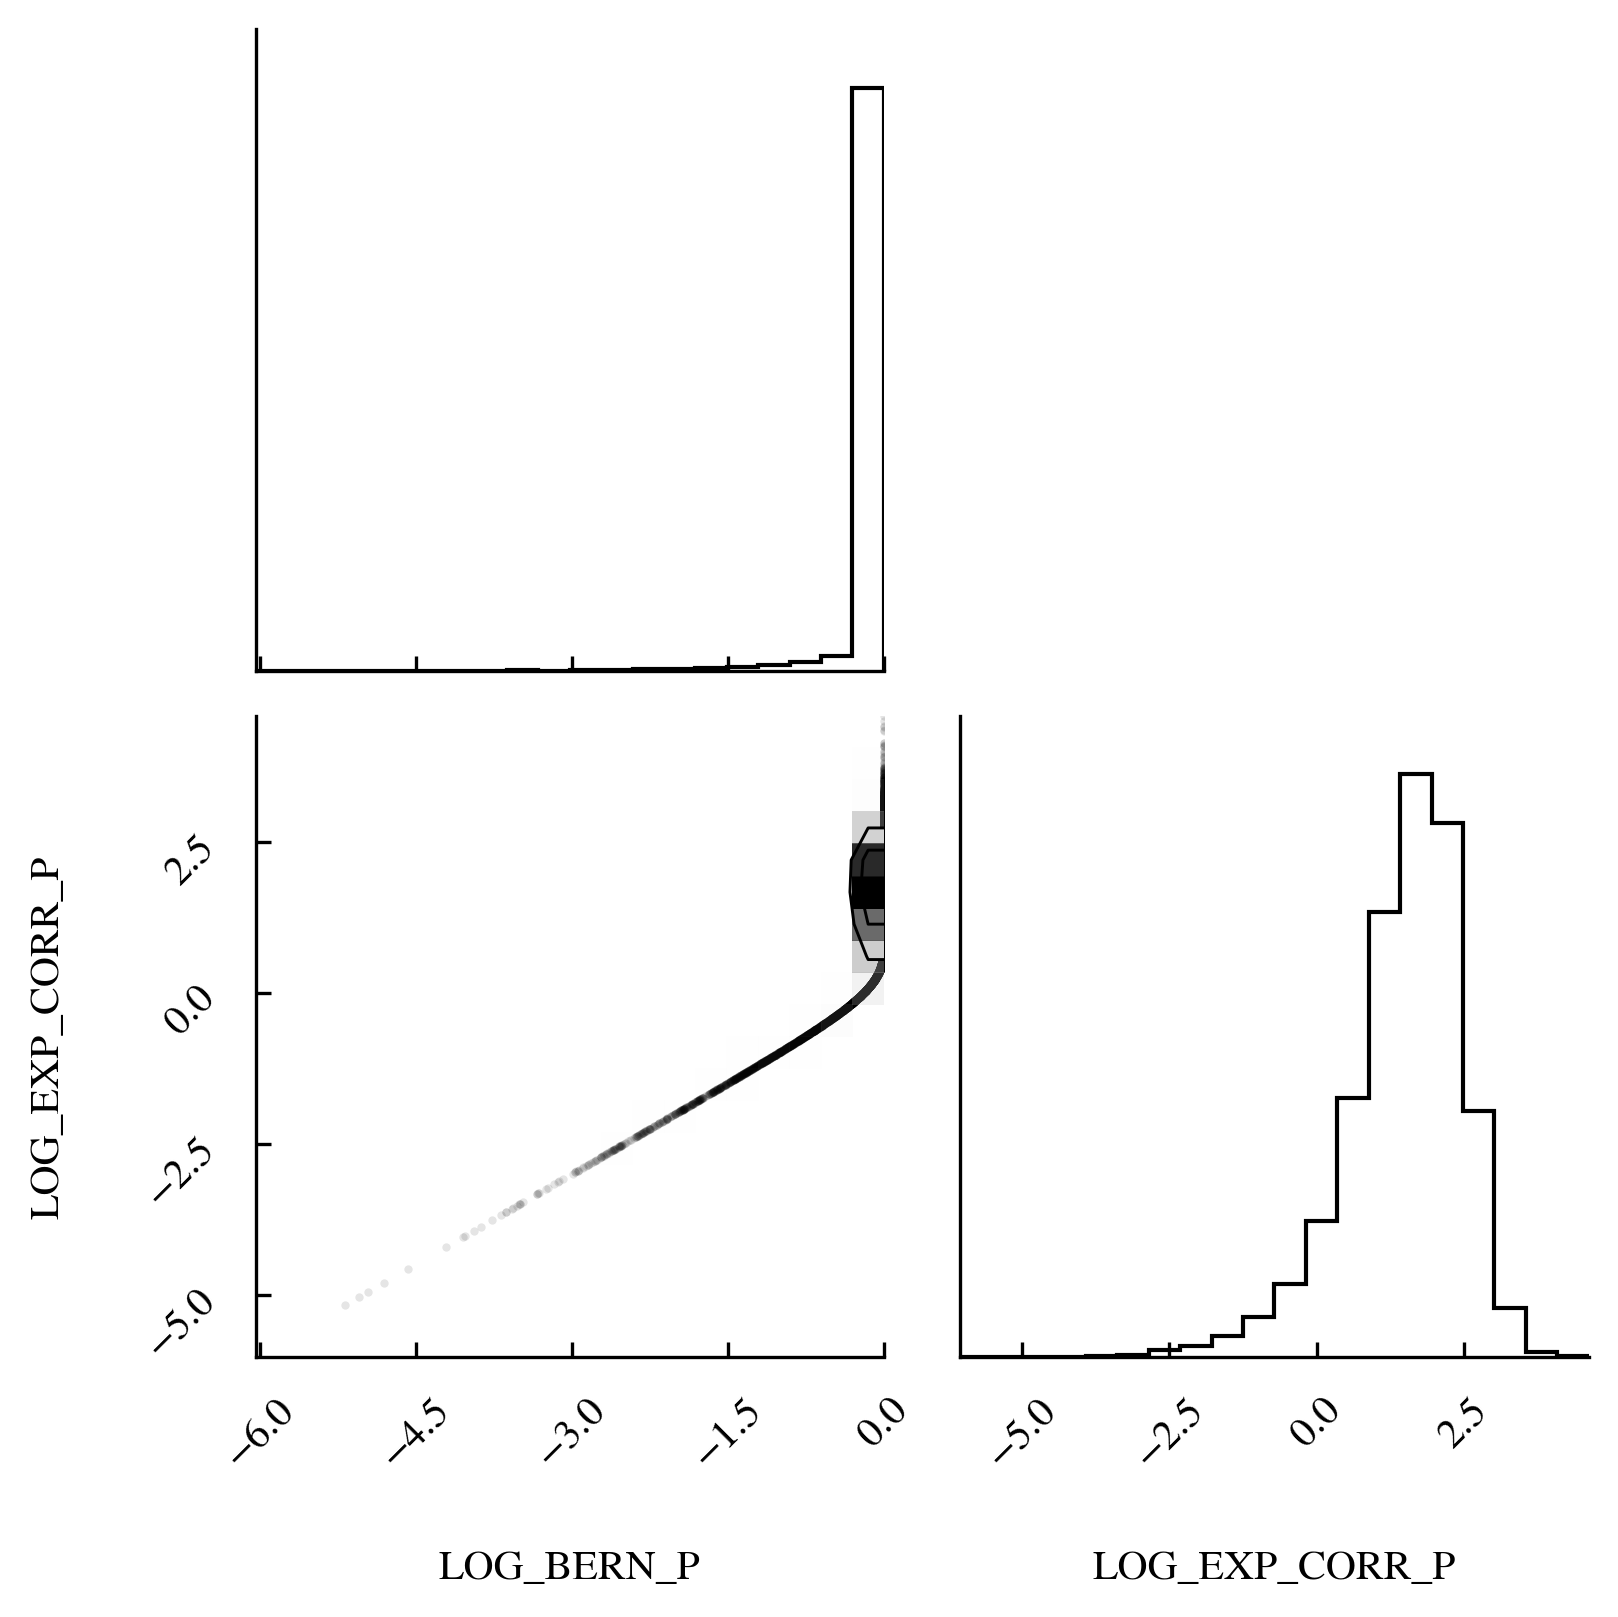

In [31]:

reduced.reduced["LOG_BERN_P"] = np.log10(reduced.reduced["BERNOULLI_P"])
reduced.reduced["LOG_EXP_CORR_P"] = np.log10(reduced.reduced["EXP_CORRECTED_P"])
fig = corner(reduced.reduced[leftover].to_pandas(), var_names=["LOG_BERN_P","LOG_EXP_CORR_P"])

In [ ]:
A = reduced.reduced[~pval_0_mask]
A.sort("LAMBDA_RATIO_SIGNIFICANCE")
cand = A[2]

luminosity = np.sum(cand["ENERGY"])/cand["dt"] * 1.6 * (4*np.pi * (3e24)**2 / 1e5) * 1e9
print(luminosity)

In [ ]:
reduced.reduced["LOG_SIGNIFICANCE"] = np.log10(reduced.reduced["LAMBDA_RATIO_SIGNIFICANCE"])


In [ ]:
from scipy.stats import spearmanr
spearmanR = spearmanr(reduced.reduced[~pval_0_mask]["LAMBDA_RATIO_SIGNIFICANCE"].data,reduced.reduced[~pval_0_mask]["PNT_DISTANCE"].data)
print(spearmanR)

In [ ]:
spearmanR.correlation

In [ ]:
fig = corner(reduced.reduced[~pval_0_mask].to_pandas(),var_names=["PNT_DISTANCE","LOG_SIGNIFICANCE"],labels=[r"$d(\mathrm{mplet}, PNT)$ [deg]",r"$^{10}\log(P)$"])
fig.text(.55,.7,f"Spearman rank correlation: {np.round(spearmanR.correlation,2)}\n with p-value {spearmanR.pvalue}",fontsize="large")
fig.set_size_inches(4,4)
plt.savefig("figures/combined/pnt-significance-correlation.png",facecolor="white",dpi=300)

In [ ]:
with open("pkl_jugs/plotter_pval0/multiplets.pkl","wb") as f:
    dill.dump(reduced[pval_0_mask],f)

## badly marked: 18361

In [ ]:
reduced[pval_0_mask]["OBS_ID"].data

In [ ]:
h = vis.hist(reduced["ANGULAR_MEASURE_DEG"],histtype="step",bins="freedman")
plt.title("Mean of multiplet photon distance to median coordinate")
plt.xlabel("Distance [deg]")
plt.ylabel("Counts")

In [ ]:
min(reduced["LAMBDA_RATIO_SIGNIFICANCE"][~pval_0_mask]),max(reduced["LAMBDA_RATIO_SIGNIFICANCE"])

Significance histogram excluding pval==0

In [ ]:
plt.figure(figsize=(5,2.5))
h = vis.hist(np.log10(reduced.reduced[~pval_0_mask]["LAMBDA_RATIO_SIGNIFICANCE"]),histtype="step",bins=np.linspace(-14,0))
plt.yscale("log")
plt.xlabel(r"$^{10}\log(P)$")
plt.ylabel("Counts")
plt.title("$P(N\geq N_m ~|~ \lambda)$",loc="left")
# plt.savefig("figures/combined/lambda_ratio_significance.pdf")
plt.savefig("figures/combined/lambda_ratio_significance.png",facecolor="white",dpi=300)
# h = vis.hist(reduced["MPLET_DT_LAMBDA"],histtype="step",bins=np.linspace(6e-19,9.5e-19,100))

In [ ]:
reduced.sort('dt')
pval_0_mask = reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.

len(np.unique(reduced[pval_0_mask]["OBS_ID"]))

In [ ]:
h = vis.hist(reduced["dt"][reduced["LAMBDA_RATIO_SIGNIFICANCE"] < 1e-5],histtype="step",bins="freedman")
# reduced[(reduced["LAMBDA_RATIO_SIGNIFICANCE"] < 1e-7)*(reduced["dt"] > 27e8)]

In [ ]:
candidates = reduced[reduced["POISSON_SIGNIFICANCE"] < 1e-5]

### To do

1. Check fit compared to histogram and mplet dt
2. Verify on a skymap that the masked photons correspond to near the source
3. Do a time spread of the photon arrival times to guess if a cloud is passing by
4. Do a gammapy analysis
5. Ask victor if the m87 run is excluded (done)
6. check GRBCAT

In [ ]:
ds = scani.getDataStores()
obs = [myds.get_observations(candidates["OBS_ID"],skip_missing=True) for myds in ds]
m87_obs = obs[1][0]
m87_mplet = candidates[-1]


In [ ]:
m87_mplet

In [ ]:
m87_rundist = scani.sphere_dist(m87_obs.events.table["RA"].data,m87_obs.events.table["DEC"].data,m87_mplet["MEDIAN_RA"],m87_mplet["MEDIAN_DEC"])

plt.scatter(1e-9*(m87_obs.events.table[m87_rundist<.1]["TIME"]),np.zeros_like(m87_obs.events.table[m87_rundist<.1]["TIME"]),marker="v",s=1)

In [ ]:
expon.fit(np.diff(np.sort(m87_obs.events.table[m87_rundist < 0.1]["TIME"])),floc=0)

In [ ]:
dwarf = SkyCoord(283.775,-30.483,frame="fk5",unit="deg")
dwarf.separation(reduced[(reduced["OBS_ID"]==64292) * (reduced["POISSON_SIGNIFICANCE"] < 1e-5)]["SkyCoord"])

In [ ]:
h = vis.hist(np.log10(reduced["dt"]),bins="freedman",histtype="step")
plt.yscale("log")

In [ ]:
N = 3
livetime = 1680
bursttime = 3
rate = N/livetime

lamb = rate*bursttime
sum = 1
for i in range(3):
    sum -= (lamb)**i * np.exp(-lamb) / factorial(i)

sum


In [1]:
import scanner_interpretation as scani
import dill
from gammapy.maps import WcsNDMap
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
with open(
        "mc_scanner/real_dataset_dumps/hbl/stacked_datasets.pkl", "rb"
    ) as f:
        exposure: WcsNDMap = dill.load(f).exposure

spatial_exp: WcsNDMap = exposure.sum_over_axes(keepdims=False)

red = scani.Reduced("pkl_jugs/reduced_correctedP_020923.pkl")
omask = red.reduced["OBS_ID"] == 35007

row = red.reduced[omask]

idx_signal = np.array(spatial_exp.geom.coord_to_idx(row["SkyCoord"])).flatten()
print("idx",idx_signal)
moved: SkyCoord = row["SkyCoord"].directional_offset_by(
        0.0 * u.deg, row["ANGULAR_MEASURE_DEG"] * u.deg
    )
idx_moved = np.array(spatial_exp.geom.coord_to_idx(moved)).flatten()
print("idx moved",idx_moved)

contained = scani.get_contained_indices(*spatial_exp.data.shape, coord = idx_moved, center = idx_signal)

for item in contained:
        print(len(item))


idx [119  67]
idx moved [119  70]
0.0 223.6604569431083 3.0
29
29
